# Cost Function Script

The cost function is based on that found in Equation 1 of [Ward et al. (2010)](https://www.sciencedirect.com/science/article/pii/S0924796309003431?casa_token=S1tQ2yuwGQgAAAAA:lCpjjVEqP4bJWA4xg5kOjG028PuyDQdcOHfTw5KtVLoM0kkonEa15ZinoxIopsWH1nTmhNRExw).

$$
J = \frac{1}{M} \sum_{m=1}^{M} W_m^2 \frac{1}{N_m} \sum_{n=1}^{N_m} (a - \hat{a})_{n,m}^2
$$

$M$: number of data targets \
$N_m$: number of observations for each target \
$\hat{a}$: observed value of data target $m$ at location/time $n$ \
$a$: model equivalent of $\hat{a}$ \
$W_m$: weight function; $W_m = \frac{C_m}{\sigma_m}$

**Note**: Currently, I am neglecting the $\frac{1}{M}$ term. This should not present any problems as long as each simulation has the same targets.

The below script demonstrates how the cost is calculated using a single-year run from model spin-up. This same script can be run for any model simulation, and each run of the script produces an output NetCDF file containing the following:
1. Monthly averaged observations of each target variable
2. Monthly averaged model outputs of each target variable
3. The cost associated with the discrepancy between observations and model outputs for each target
4. Metadata on all parameter values
5. Further metadata about the model run and its results.

## Workflow Outline

1. Import all observational data.
    1. NBFSMN bottom data for pH, DO, T, and S: `"/Users/akbaskind/Desktop/Data/Narragansett Bay Water Quality/NBFSMN_05_19_bottom.csv"`
    2. NBFSMN surface data for pH, DO, T, and S: `"/Users/akbaskind/Desktop/Data/Narragansett Bay Water Quality/NBFSMN_05_19_surface.csv"`
    3. Primary production estimates from [Oviatt et al., 2002](https://www.sciencedirect.com/science/article/pii/S0272771401908728): `"/Users/akbaskind/Desktop/ROMS_Code_Feb2025/OviattPPMeasurements.csv"`
    4. [Nutrient (NO3) data from the phytoplankton time series](https://web.uri.edu/gso/research/plankton/data/): `"/Users/akbaskind/Desktop/Data/Narragansett Bay Nutrients/PLT_Nutrients.csv"`
    5. [Nutrient (Si) data from the phytoplankton time series](https://web.uri.edu/gso/research/plankton/data/): `"/Users/akbaskind/Desktop/Data/Narragansett Bay Nutrients/PLT_Nutrients_Si.csv"`
    6. Eventually, pCO2 can be added from NBFSMN pH and alkalinity estimated from NBFSMN salinity.
2. Process observational data
3. Take monthly averages of observational data when applicable.
4. Format observational data to match structure of model output.
5. Do it all again for the model outputs.
6. Put everything into a single dataset that includes thorough metadata and parameter values.
7. Plot the results.
8. Calculate the cost.
    


In [1]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math


# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns
import pyleoclim as pyleo
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

# Helper Functions

In [2]:
def mmolm3_to_mgL(O2):
    # O2: 32g / 1mol -- 32mg / 1mmol
    # mmol * 32mg / 1mmol = mg
    O2 = O2 * 32
    
    # m3 -- > L
    # 1m3 = 1000L
    # mg/m3 * 1m3/1000L = mg/L
    O2 = O2 / 1000
    return O2

def mgL_to_mmolm3(O2):
    # O2: 32g / 1mol -- 32mg / 1mmol
    # mmol * 32mg / 1mmol = mg
    # mg * 1mmol/32mg = mmol
    O2 = O2 / 32
    
    # L --> m3
    # 1m3 = 1000L
    # mmol/L * 1000L/1m3 = mmol/m3
    O2 = O2 * 1000
    return O2

In [3]:
sta_nos = np.asarray([51,54,55,57,58,8])
sta_names = np.asarray(['BR', 'MV', 'QP', 'TW', 'GB', 'GD'])

# Import Observational Data

## NBFSMN data for pH, DO, T, and S

NBFSMN data can be found [here](https://web.uri.edu/wp-content/uploads/sites/916/nbfsmn_daily_means_thru_2019.csv) through the [MERL website](https://web.uri.edu/gso/research/marine-ecosystems-research-laboratory/datasets/). Data are provided as daily averages at all the NBFSMN sites. For the purposes of tuning, we have selected 6 of those sites: Bullocks Reach, Mount View, Quonset Point, T-Wharf, Greenwich Bay, and GSO Dock. pH is NBS scale. DO is mg/L.

### Bottom

In [4]:
# Import data
ds = pd.read_csv('/Users/akbaskind/Desktop/Data/Narragansett Bay Water Quality/NBFSMN_05_19_bottom.csv')

# Select year
ds = ds[ds['Year'] == 2005]
ds = ds.reset_index(drop = True)

# Select sites: BR, MV, QP, GB, GD, and TW
ds = ds[(ds['site'] == 'MV') | (ds['site'] == 'QP') | (ds['site'] == 'GB') | (ds['site'] == 'GD') | (ds['site'] == 'TW') | (ds['site'] == 'BR')]
ds = ds.reset_index(drop = True)

# Convert oxygen units
ds['DO [mmol/m3]'] = mgL_to_mmolm3(ds['DO [mg/L]'])

# Reformatting dataframe
ds = ds[['date', 'site', 'S', 'T', 'pH [NBS]', 'Month', 'DO [mmol/m3]']]
ds["date"] = pd.to_datetime(ds["date"], errors = 'coerce')

# Take means and stds
ds_bottom_mn = ds.groupby([ds['Month'], ds['site']]).mean().reset_index()
ds_bottom_std = ds.groupby([ds['Month'], ds['site']]).std().reset_index()

# Storage dataframe for bottom NBFSMN
temp = {'Site': ds_bottom_mn['site'],
        'Date': ds_bottom_mn['site'],
        'Month': ds_bottom_mn['Month'],
        'S mean': ds_bottom_mn['S'], 
        'T mean': ds_bottom_mn['T'],
        'pH mean': ds_bottom_mn['pH [NBS]'],
        'DO mean': ds_bottom_mn['DO [mmol/m3]'],
        'S std': ds_bottom_std['S'], 
        'T std': ds_bottom_std['T'],
        'pH std': ds_bottom_std['pH [NBS]'],
        'DO std': ds_bottom_std['DO [mmol/m3]'],
       }
df_bottom = pd.DataFrame(temp)

### Surface

In [5]:
# Import data
ds = pd.read_csv('/Users/akbaskind/Desktop/Data/Narragansett Bay Water Quality/NBFSMN_05_19_surface.csv')

# Select year
ds = ds[ds['Year'] == 2005]
ds = ds.reset_index(drop = True)

# Select sites: BR, MV, QP, GB, GD, and TW
ds = ds[(ds['site'] == 'MV') | (ds['site'] == 'QP') | (ds['site'] == 'GB') | (ds['site'] == 'GD') | (ds['site'] == 'TW') | (ds['site'] == 'BR')]
ds = ds.reset_index(drop = True)

# Convert oxygen units
ds['DO [mmol/m3]'] = mgL_to_mmolm3(ds['DO'])

# Reformatting dataframe
ds = ds[['date', 'site', 'S', 'T', 'pH', 'Month', 'DO [mmol/m3]']]
ds["date"] = pd.to_datetime(ds["date"], errors = 'coerce')

# Take averages and stds
ds_surface_mn = ds.groupby([ds['Month'], ds['site']]).mean().reset_index()
ds_surface_std = ds.groupby([ds['Month'], ds['site']]).std().reset_index()

# Storage dataframe for surface NBFSMN
temp = {'Site': ds_surface_mn['site'],
        'Date': ds_surface_mn['date'],
        'Month': ds_surface_mn['Month'],
        'S mean': ds_surface_mn['S'], 
        'T mean': ds_surface_mn['T'],
        'pH mean': ds_surface_mn['pH'],
        'DO mean': ds_surface_mn['DO [mmol/m3]'],
        'S std': ds_surface_std['S'], 
        'T std': ds_surface_std['T'],
        'pH std': ds_surface_std['pH'],
        'DO std': ds_surface_std['DO [mmol/m3]'],
       }
df_surface = pd.DataFrame(temp)

### Reformatting NBFSMN data to match model output

Since the NBFSMN data does not have each month of the year, we need to fill in months with no data with NaN.

In [6]:
# Storage array dimensions: 6 stations X 2 depths (surface and bottom) X 12 months
pH = np.zeros((6,2,12))
pH[:] = np.nan

DO = np.zeros((6,2,12))
DO[:] = np.nan

salt = np.zeros((6,2,12))
salt[:] = np.nan

temp = np.zeros((6,2,12))
temp[:] = np.nan

var = "pH mean"
for SITE in sta_names:
    if SITE == "BR":
        j = 0
    elif SITE == "MV":
        j = 1
    elif SITE == "QP":
        j = 2
    elif SITE == "TW":
        j = 3
    elif SITE == "GB":
        j = 4
    elif SITE == "GD":
        j = 5
        
    for i in df_surface['Month'][df_surface['Site'] == SITE]:
        pH[j,0,int(i)-1] = df_surface[var][(df_surface['Site'] == SITE) & ((df_surface['Month'] == i))].values[0]
        
    for i in df_bottom['Month'][df_bottom['Site'] == SITE]:
        fillval = df_bottom[var][(df_bottom['Site'] == SITE) & ((df_bottom['Month'] == i))]
        if fillval.size > 0:
            pH[j,1,int(i)-1] = df_bottom[var][(df_bottom['Site'] == SITE) & ((df_bottom['Month'] == i))].values[0]
            
var = "DO mean"
for SITE in sta_names:
    if SITE == "BR":
        j = 0
    elif SITE == "MV":
        j = 1
    elif SITE == "QP":
        j = 2
    elif SITE == "TW":
        j = 3
    elif SITE == "GB":
        j = 4
    elif SITE == "GD":
        j = 5
        
    for i in df_surface['Month'][df_surface['Site'] == SITE]:
        DO[j,0,int(i)-1] = df_surface[var][(df_surface['Site'] == SITE) & ((df_surface['Month'] == i))].values[0]
        
    for i in df_bottom['Month'][df_bottom['Site'] == SITE]:
        fillval = df_bottom[var][(df_bottom['Site'] == SITE) & ((df_bottom['Month'] == i))]
        if fillval.size > 0:
            DO[j,1,int(i)-1] = df_bottom[var][(df_bottom['Site'] == SITE) & ((df_bottom['Month'] == i))].values[0]
            
var = "S mean"
for SITE in sta_names:
    if SITE == "BR":
        j = 0
    elif SITE == "MV":
        j = 1
    elif SITE == "QP":
        j = 2
    elif SITE == "TW":
        j = 3
    elif SITE == "GB":
        j = 4
    elif SITE == "GD":
        j = 5
        
    for i in df_surface['Month'][df_surface['Site'] == SITE]:
        salt[j,0,int(i)-1] = df_surface[var][(df_surface['Site'] == SITE) & ((df_surface['Month'] == i))].values[0]
        
    for i in df_bottom['Month'][df_bottom['Site'] == SITE]:
        fillval = df_bottom[var][(df_bottom['Site'] == SITE) & ((df_bottom['Month'] == i))]
        if fillval.size > 0:
            salt[j,1,int(i)-1] = df_bottom[var][(df_bottom['Site'] == SITE) & ((df_bottom['Month'] == i))].values[0]
            
var = "T mean"
for SITE in sta_names:
    if SITE == "BR":
        j = 0
    elif SITE == "MV":
        j = 1
    elif SITE == "QP":
        j = 2
    elif SITE == "TW":
        j = 3
    elif SITE == "GB":
        j = 4
    elif SITE == "GD":
        j = 5
        
    for i in df_surface['Month'][df_surface['Site'] == SITE]:
        temp[j,0,int(i)-1] = df_surface[var][(df_surface['Site'] == SITE) & ((df_surface['Month'] == i))].values[0]
        
    for i in df_bottom['Month'][df_bottom['Site'] == SITE]:
        fillval = df_bottom[var][(df_bottom['Site'] == SITE) & ((df_bottom['Month'] == i))]
        if fillval.size > 0:
            temp[j,1,int(i)-1] = df_bottom[var][(df_bottom['Site'] == SITE) & ((df_bottom['Month'] == i))].values[0]

## Primary production data from [Oviatt et al (2002)](https://www.sciencedirect.com/science/article/pii/S0272771401908728)

Primary production for 1997-1998 in order of ascending station number

In [7]:
# Import data
pp = pd.read_csv('/Users/akbaskind/Desktop/ROMS_Code_Feb2025/OviattPPMeasurements.csv')

# Correct data types from str to numeric
pp['Station Number'] = pd.to_numeric(pp['Station Number'])
pp['Production'] = pd.to_numeric(pp['C-14 Production Estimate (gC m-2 y-1)'])

# Reformatting and sorting by station number
pp = pp[['Station Number', 'Production']]
pp = pp.sort_values(by=['Station Number']).reset_index(drop = True)

## Nutrient data from PLT

Nutrient data can be found [online](https://web.uri.edu/gso/wp-content/uploads/sites/916/Nutrient-Data-Master-Sheet.xlsx). This data correspond to the Narragansett Bay Long Term Phytoplankton Time Series site, which is model station #68 (Python) or #69 (Matlab). For the most part, the data have weekly resolutions.

What is available in the data file:
- surface NO3 from 2003 to 2023
- surface NH4 from 2003 to 2023
- bottom NO3 from 2003 to 2013
- bottom NH4 from 2003 to 2013
- surface Si from 2003 to 2021
- bottom Si from 2003 to 2013-ish, but data starts getting sparse for later dates

All nutrient data are provided in units of uM (umol L<sup>-1</sup> ), which, if I did my calculation correctly, should be equal to the model's native units of mmol m<sup>-3</sup>.
$$
\frac{\mu mol}{L} * \frac{mmol}{10^3 \mu mol} * \frac{10^3 L}{m^3} = \frac{mmol}{m^3}
$$

As of 2/26/2025: Only surface NO3 being used because of the data limitations we will face with bottom data for later years. Both surface and bottom Si are used, but bottom Si might be eliminated for reasons similar to NO3.


### Surface NO3

In [8]:
# Import data
nut = pd.read_csv('/Users/akbaskind/Desktop/Data/Narragansett Bay Nutrients/PLT_Nutrients.csv')

# Correct data types and fill "nd" with NaN
nut["Date"] = pd.to_datetime(nut["Date"], errors = 'coerce')
nut['NO3 (uM)'][nut['NO3 (uM)'] == 'nd'] = np.nan
nut['NO3 (uM)'] = pd.to_numeric(nut['NO3 (uM)'])

# Select year
nut = nut[nut['Date'].dt.year == 2005].reset_index(drop = True)

# Monthly averages
nut12 = nut['NO3 (uM)'].groupby([nut['Date'].dt.month]).mean()

### Surface and Bottom Si

In [9]:
# Import data
si = pd.read_csv('/Users/akbaskind/Desktop/Data/Narragansett Bay Nutrients/PLT_Nutrients_Si.csv')

# Correct data types and fill "nd" with NaN
si["DATE"] = pd.to_datetime(si["DATE"], errors = 'coerce')
si['Surface Si'][si['Surface Si'] == 'nd'] = np.nan
si['Bottom Is'][si['Bottom Is'] == 'nd'] = np.nan
si['Surface Si'] = pd.to_numeric(si['Surface Si'])
si['Bottom Si'] = pd.to_numeric(si['Bottom Is'])

# Select year
si = si[si['DATE'].dt.year == 2005].reset_index(drop = True)
si = si[['DATE', 'Surface Si', 'Bottom Si']]

# Monthly averages
si12 = si.groupby([si['DATE'].dt.month]).mean()

In [10]:
obs_si = np.zeros([2,12])
obs_si[0,:] = si12['Surface Si']
obs_si[1,:] = si12['Bottom Si']

# Station output from model 

In [11]:
df_params = xr.open_mfdataset('/Users/akbaskind/Desktop/COST_FILES/ocean_sta_2005_CTRL.nc')

## Extract parameter values

Parameter values are stored rather clumsily in the output NetCDF file produced by this script. A more user-friendly version can be found in [Abby's Google Drive](https://docs.google.com/spreadsheets/d/1OR282RDmb8W7CVVoeFP3XP6ODTJrmAyC4qz8AQfh34M/edit?gid=1010281991#gid=1010281991).

In [12]:
# Import parameter list
param_list = pd.read_csv('/Users/akbaskind/Desktop/ROMS_Code_Feb2025/ParameterList.csv')
param_list = param_list[0:74]
params = np.asarray(param_list['Parameter Name'])

# Storage array for parameter values
pars = np.zeros(74)
for n,p in enumerate(params):
    item = df_params[p].values.tolist()
    if type(item) == list:
        item = item[0]
    pars[n] = item

## Process station file

When extracting stations used for NBFSMN data, the stations are extracted in the following order: BR, MV, QP, TW, GB, and GD. Upon subselecting the stations, the order is maintained but station indicies are changed from [51, 54, 55, 57, 58, 8] to [0, 1, 2, 3, 4, 5]

| Site | Original Index | New Index |
| ----------- | ----------- |  ----------- |
| BR | 51 | 0 |
| MV | 54 | 1 |
| QP | 55 | 2 |
| TW | 57 | 3 |
| GB | 58 | 4 |
| GD |  8 | 5 |

In [13]:
# Subset just the variables needed
df = df_params[['temp', 'salt', 'TIC', 'alkalinity', 'oxygen', 'h', 'NO3', 'SiOH4']]

# Subset only the sites needed
# Subsetted in this order: BR, MV, QP, TW, GB, and GD 
df2 = df.isel(station = 68)
df = df.isel(station = sta_nos)

# Calculate pH
results = pyco2.sys(par1 = df['alkalinity'], par1_type = 1,
                     par2 = df['TIC'], par2_type = 2, 
                     temperature = df['temp'], 
                     salinity = df['salt'], 
                     pressure = gsw.p_from_z(df['h']*df['s_rho'], 41)
                    )

# Storage array that matches model data structure for pH
df['pH'] = xr.zeros_like(df['oxygen'])
df['pH'][:] = np.nan
df['pH'] = xr.DataArray(results['pH_nbs'], dims=['ocean_time','station','s_rho'], name='pH')

# Take monthly averages
DF = df.groupby(df['ocean_time'].dt.month).mean()
DF2 = df2.groupby(df2['ocean_time'].dt.month).mean()

In [14]:
# Storage arrays for station pH, DO, T, and S
sta_ph = np.zeros([6,2,12])
sta_do = np.zeros([6,2,12])
sta_temp = np.zeros([6,2,12])
sta_salt = np.zeros([6,2,12])

for i,j in enumerate(DF.station):
    var = 'pH'
    sta_ph[i,0,:] = DF[var].isel(station = j, s_rho = 9)
    sta_ph[i,1,:] = DF[var].isel(station = j, s_rho = 0)
    
    var = 'oxygen'
    sta_do[i,0,:] = DF[var].isel(station = j, s_rho = 9)
    sta_do[i,1,:] = DF[var].isel(station = j, s_rho = 0)
    
    var = 'temp'
    sta_temp[i,0,:] = DF[var].isel(station = j, s_rho = 9)
    sta_temp[i,1,:] = DF[var].isel(station = j, s_rho = 0)
    
    var = 'salt'
    sta_salt[i,0,:] = DF[var].isel(station = j, s_rho = 9)
    sta_salt[i,1,:] = DF[var].isel(station = j, s_rho = 0)
    
# Storage array for PLT surface NO3
sta_NO3 = np.zeros([12])
sta_NO3 = DF2['NO3'].isel(s_rho = 9).values

# Storage array for PLT Si
sta_Si = np.zeros([2,12])
sta_Si[0,:] = DF2['SiOH4'].isel(s_rho = 9).values
sta_Si[1,:] = DF2['SiOH4'].isel(s_rho = 0).values

# Model primary production

Primary production from the model output is calculated with the following code: `/Users/akbaskind/Documents/MATLAB/ROMS_PP/Cosine_phyto_prod_resp.m`. The Matlab script calculates depth integrated net daytime primary production (gC m<sup>-2</sup> yr<sup>-1</sup>) for the 16 Oviatt stations and writes the results to a CSV/


In [15]:
ROMS_PP = pd.read_csv('/Users/akbaskind/Desktop/COST_FILES/production_2005_CTRL.csv')

# All data in a single dataset

Stored in an [Xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html).

## Metadata

The metadata contains information regarding units, data treatment, observation year, model year, site, etc.

In [16]:
NBFSMNlink = 'https://web.uri.edu/wp-content/uploads/sites/916/nbfsmn_daily_means_thru_2019.csv'
pH_obs_attr = {'units': 'NBS scale', 'Data Link': NBFSMNlink, 'Year': '2005', 'Data Treatment': 'Monthly averages'}
pH_mod_attr = {'units': 'NBS scale'}

oxygen_obs_attr = {'units': 'mmol m-3', 'Data Link': NBFSMNlink, 'Year': '2005', 'Data Treatment': 'Monthly averages'}
oxygen_mod_attr = {'units': 'mmol m-3'}

temp_obs_attr = {'units': '°C', 'Data Link': NBFSMNlink, 'Year': '2005', 'Data Treatment': 'Monthly averages'}
temp_mod_attr = {'units': '°C'}

salt_obs_attr = {'units': 'PSU', 'Data Link': NBFSMNlink, 'Year': '2005', 'Data Treatment': 'Monthly averages'}
salt_mod_attr = {'units': 'PSU'}

NO3_obs_attr = {'units': 'mmol m-3', 'site': 'phytoplankton time series site', 'link': 'https://web.uri.edu/gso/research/plankton/data/', 'depth': 'surface'}
NO3_mod_attr = {'units': 'mmol m-3', 'site': 'phytoplankton time series site', 'depth': 'surface'}

Si_obs_attr = {'units': 'mmol m-3', 'site': 'phytoplankton time series site', 'link': 'https://web.uri.edu/gso/research/plankton/data/', 'depth': 'surface [0] and bottom [1]'}
Si_mod_attr = {'units': 'mmol m-3', 'site': 'phytoplankton time series site', 'depth': 'surface [0] and bottom [1]'}

PP_obs_attr = {'units': 'gC m-2 yr-1', 
               'Citation': 'Oviatt, C., Keller, A., & Reed, L. (2002). Annual primary production in Narragansett Bay with no bay-wide winter–spring phytoplankton bloom. Estuarine, Coastal and Shelf Science, 54(6), 1013-1026.', 
               'Year': '1997-1998',
               'Description': 'depth integrated net daytime primary production from C14 incubations at 16 sites in Narragansett Bay'}
PP_mod_attr = {'units': 'gC m-2 yr-1', 'Source code': 'unity:/home/abaskind_uri_edu/misc/integrate_production_fullwatercolumn_multifile_AB.m',
               'Description': 'depth integrated net daytime primary production of both phytoplankton classes at Oviatt stations'}

note1 = "For parameters with multiple values, which are exclusively partitioning coefficients"
note2 = " for organic matter and/or their respective decay rates, only the first value of the sequence is given," 
note3 = " which generally corresponds to the labile class of OM. For full parameter values, see the spreadsheet."
param_attr = {'Description': str(np.asarray(param_list['Description '])), 'Units': str(np.asarray(param_list['Units'])), 'Notes': note1+note2+note3, 
              'Link to spreadsheet': 'https://docs.google.com/spreadsheets/d/1iDZJ_ArikoeY8c2dsS_Ef-qasBZLU_o0S6_lvbprZgE/edit?gid=0#gid=0'}

cost_attr = {'units': 'nondimensional'}

site_attr = {'Description': 'Narragansett Bay Fixed Station Monitoring Sites', 
             'BR': '0', 'MV': '1', 'QP': '2', 'TW': '3', 'GB': '4', 'GD': '5'}

depth_attr = {'Surface': '0', 'Bottom': '1'}

oviatt_stations = {'Station 1': 'West Passage', 
                   'Station 2': 'West Passage', 
                   'Station 3': 'RI Sound', 
                   'Station 4': 'East Passage', 
                   'Station 5': 'East Passage', 
                   'Station 6': 'East Passage',
                   'Station 7': 'Mt Hope Bay',
                   'Station 8': 'East Passage',
                   'Station 9': 'Providence River',
                   'Station 10': 'Providence River',
                   'Station 11': 'Providence River',
                   'Station 12': 'Providence River',
                   'Station 13': 'Providence River',
                   'Station 14': 'West Passage',
                   'Station 15': 'Greenwich Bay',
                   'Station 16': 'West Passage'
                  }

## Dataset Construction

In [17]:
ds_test = xr.Dataset(

    data_vars=dict(

        pH_obs = (["Site", "Depth", "Month"], pH, pH_obs_attr),
        
        pH_mod = (["Site", "Depth", "Month"], sta_ph, pH_mod_attr),

        oxygen_obs = (["Site", "Depth", "Month"], DO, oxygen_obs_attr),
        
        oxygen_mod = (["Site", "Depth", "Month"], sta_do, oxygen_mod_attr),
        
        temp_obs = (["Site", "Depth", "Month"], temp, temp_obs_attr),
        
        temp_mod = (["Site", "Depth", "Month"], sta_temp, temp_mod_attr),
        
        salt_obs = (["Site", "Depth", "Month"], salt, salt_obs_attr),
        
        salt_mod = (["Site", "Depth", "Month"], sta_salt, salt_mod_attr),
        
        NO3_obs = (["Month"], nut12, NO3_obs_attr),
        
        NO3_mod = (["Month"], sta_NO3, NO3_mod_attr),
        
        Si_obs = (["Depth", "Month"], obs_si, Si_obs_attr),
        
        Si_mod = (["Depth", "Month"], sta_Si, Si_mod_attr),
        
        PP_obs = (["Station"], pp['Production'], PP_obs_attr),
        
        PP_mod = (["Station"], ROMS_PP['Annual Net Daytime Production (gC/m^2/yr)'], PP_mod_attr),
        
        NO3_cost = ([], 0, cost_attr),
        
        pH_cost = (["Depth"], np.zeros(2), cost_attr),
        
        Si_cost = (["Depth"], np.zeros(2), cost_attr),
        
        oxygen_cost = (["Depth"], np.zeros(2), cost_attr),
        
        PP_cost = ([], 0, cost_attr),
        
        param_vals = (["Parameters"], pars, param_attr),

    ),

    coords=dict(

        Site = ("Site", sta_names, site_attr),

        Depth = ("Depth", np.asarray(['Surface', 'Bottom']), depth_attr),

        Month = ("Month", np.arange(1,13)), 
        
        Station = ("Station", np.arange(1,17), oviatt_stations),
        
        Parameters = ('Parameters', params, param_attr),

    ),

    attrs=dict(description="CTRL 2005", 
               rundate = '25/6/2025',
               year = "2005", 
               )

)

# Plot observations and model data

## Surface pH

Model overestimates surface pH [NBS].

Text(0.5, 0.98, 'Monthly Surface pH')

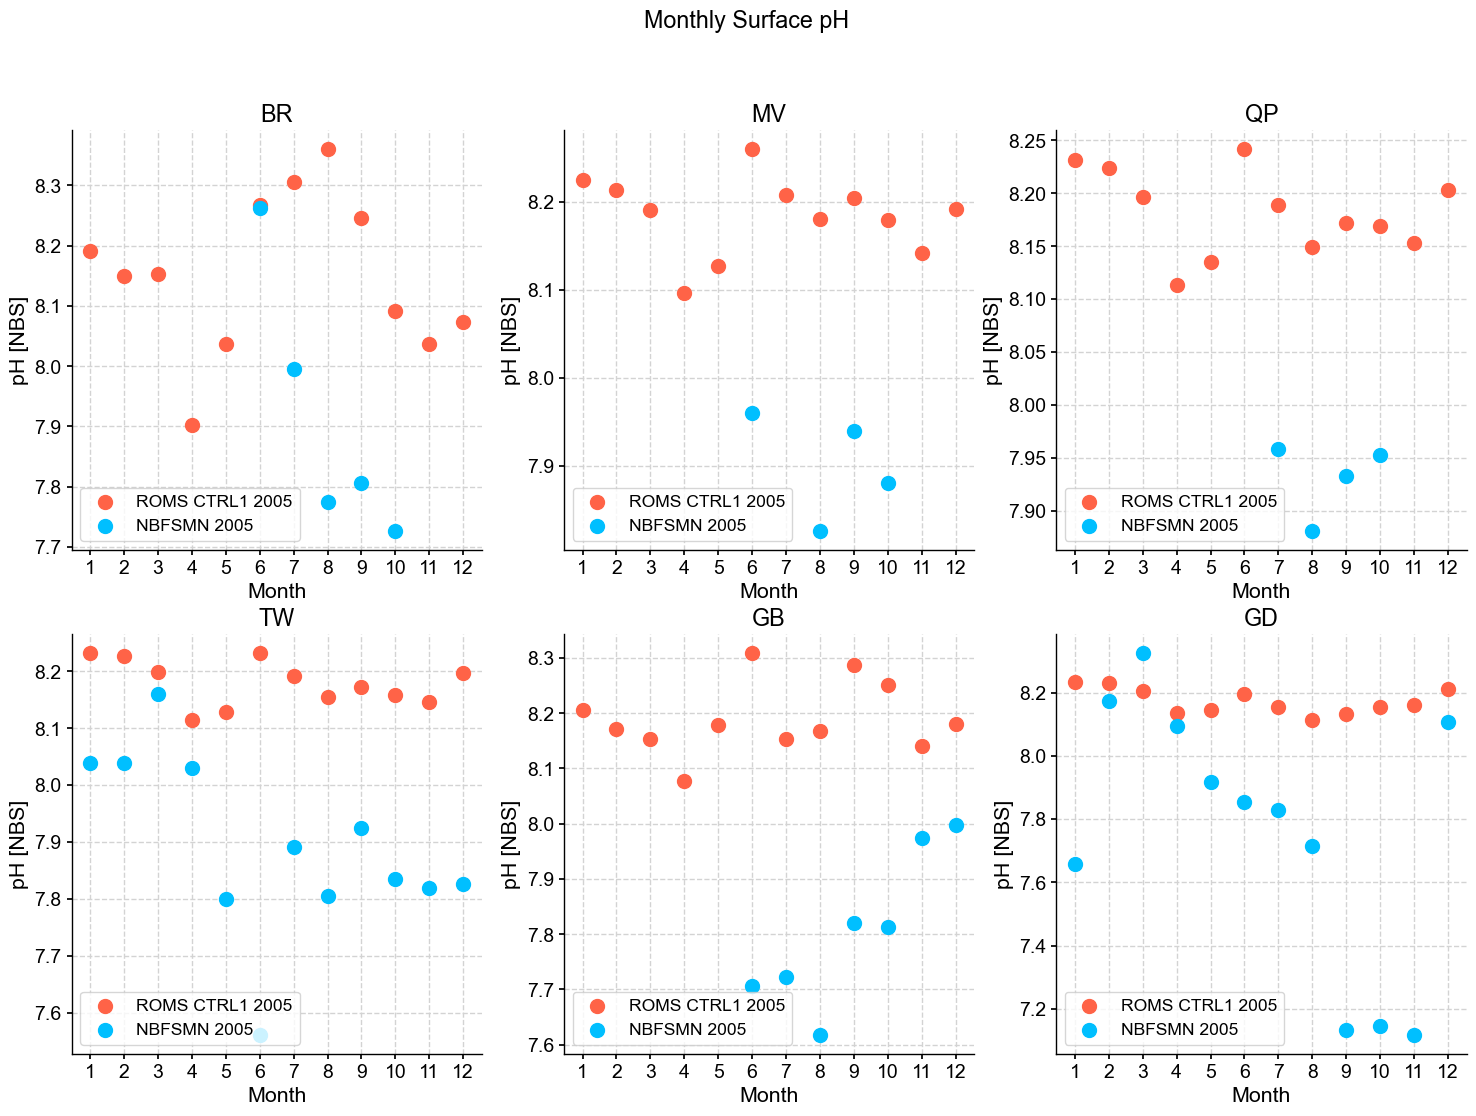

In [18]:
fig, axarr = plt.subplots(nrows = 2, ncols = 3, figsize = [18,12])
axarr = axarr.flatten()

for i in range(len(ds_test.Site)):
    name = ds_test.Site[i].values
    sta = i
    ax = axarr[i]
    data = ds_test.isel(Site = i, Depth = 0)
    ax.scatter(data['Month'], data['pH_mod'], label = 'ROMS CTRL1 2005', c = 'tomato', s = 100)
    ax.set_title(name)
    ax.scatter(data['Month'], data['pH_obs'], 
              label = 'NBFSMN 2005', c = 'deepskyblue', s = 100)
    ax.legend(frameon=True)
    ax.set_xlabel('Month')
    ax.set_xticks(np.arange(1,13))
    ax.set_ylabel('pH [NBS]') 

fig.suptitle('Monthly Surface pH')

## Bottom pH

Model REALLY overestimates bottom pH [NBS].

Text(0.5, 0.98, 'Monthly Bottom pH')

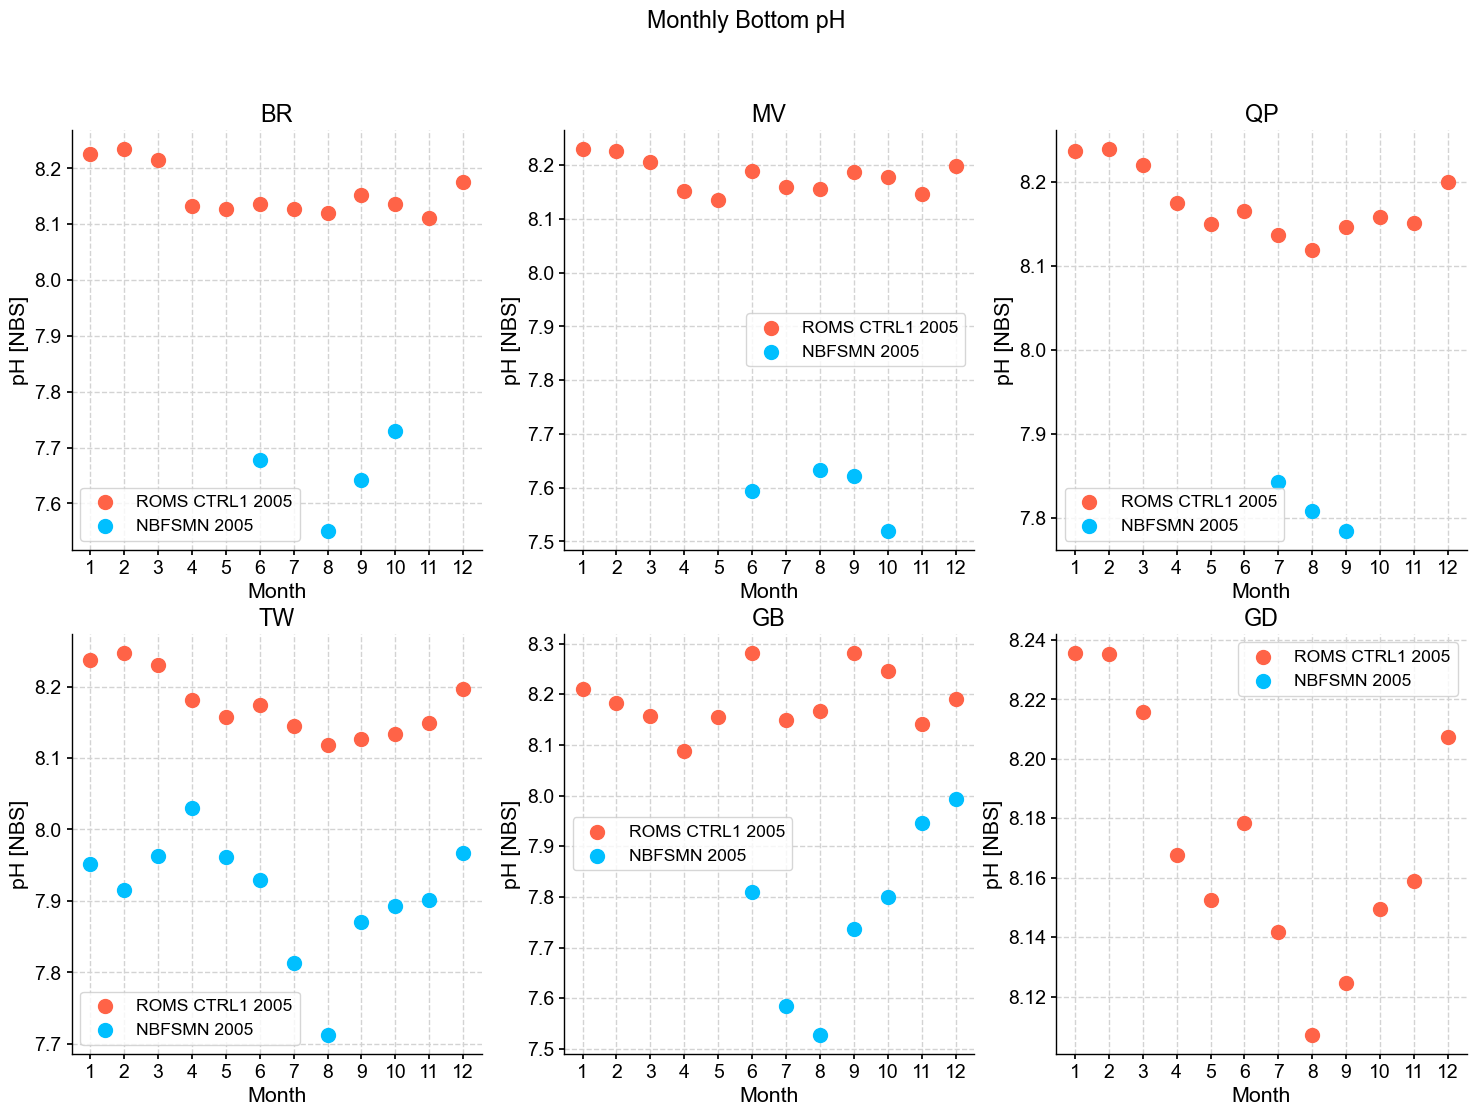

In [19]:
fig, axarr = plt.subplots(nrows = 2, ncols = 3, figsize = [18,12])
axarr = axarr.flatten()

for i in range(len(ds_test.Site)):
    name = ds_test.Site[i].values
    sta = i
    ax = axarr[i]
    data = ds_test.isel(Site = i, Depth = 1)
    ax.scatter(data['Month'], data['pH_mod'], label = 'ROMS CTRL1 2005', c = 'tomato', s = 100)
    ax.set_title(name)
    ax.scatter(data['Month'], data['pH_obs'], 
              label = 'NBFSMN 2005', c = 'deepskyblue', s = 100)
    ax.legend(frameon=True)
    ax.set_xlabel('Month')
    ax.set_xticks(np.arange(1,13))
    ax.set_ylabel('pH [NBS]') 

fig.suptitle('Monthly Bottom pH')

## Surface Oxygen

Model slightly overestimates surface oxygen. This likely won't improve much across simulations, since surface oxygen is largely controlled by the relatively fast oxygen gas exchange.

Text(0.5, 0.98, 'Monthly Surface Oxygen')

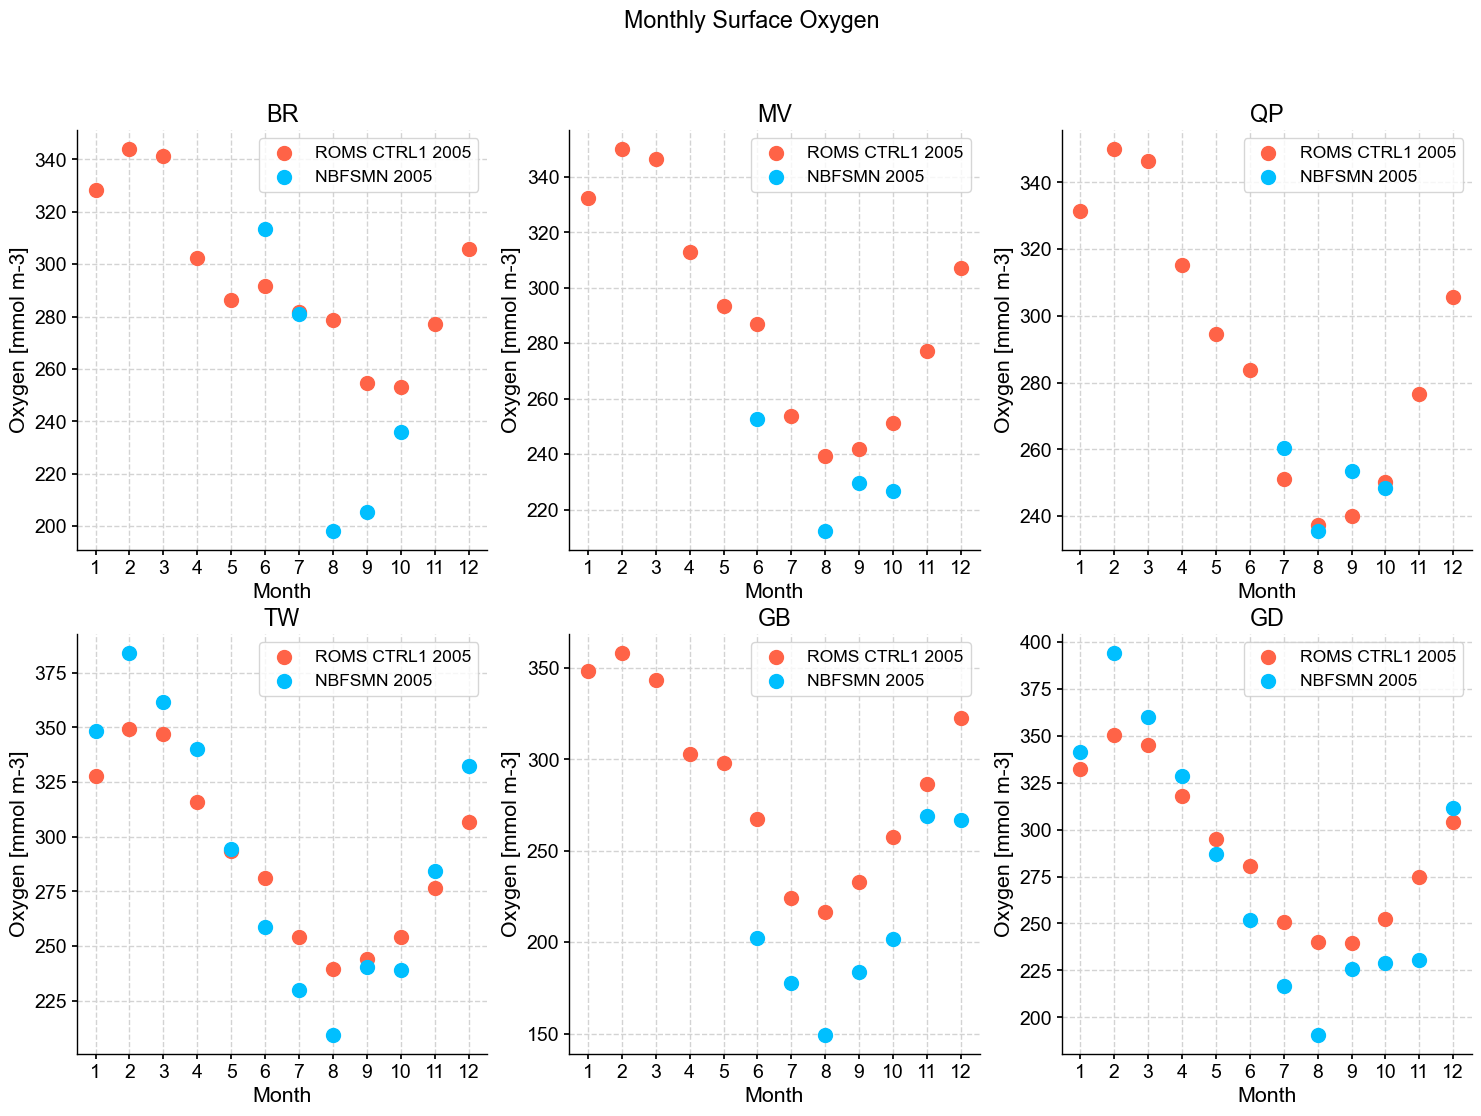

In [20]:
fig, axarr = plt.subplots(nrows = 2, ncols = 3, figsize = [18,12])
axarr = axarr.flatten()

for i in range(len(ds_test.Site)):
    name = ds_test.Site[i].values
    sta = i
    ax = axarr[i]
    data = ds_test.isel(Site = i, Depth = 0)
    ax.scatter(data['Month'], data['oxygen_mod'], label = 'ROMS CTRL1 2005', c = 'tomato', s = 100)
    ax.set_title(name)
    ax.scatter(data['Month'], data['oxygen_obs'], 
              label = 'NBFSMN 2005', c = 'deepskyblue', s = 100)
    ax.legend(frameon=True)
    ax.set_xlabel('Month')
    ax.set_xticks(np.arange(1,13))
    ax.set_ylabel('Oxygen [mmol m-3]') 

fig.suptitle('Monthly Surface Oxygen')

## Bottom Oxygen

Model overestimates bottom oxygen, particularly in summer. However, all signs suggest the seasonal cycle matches observations adequately.

Text(0.5, 0.98, 'Monthly Bottom Oxygen')

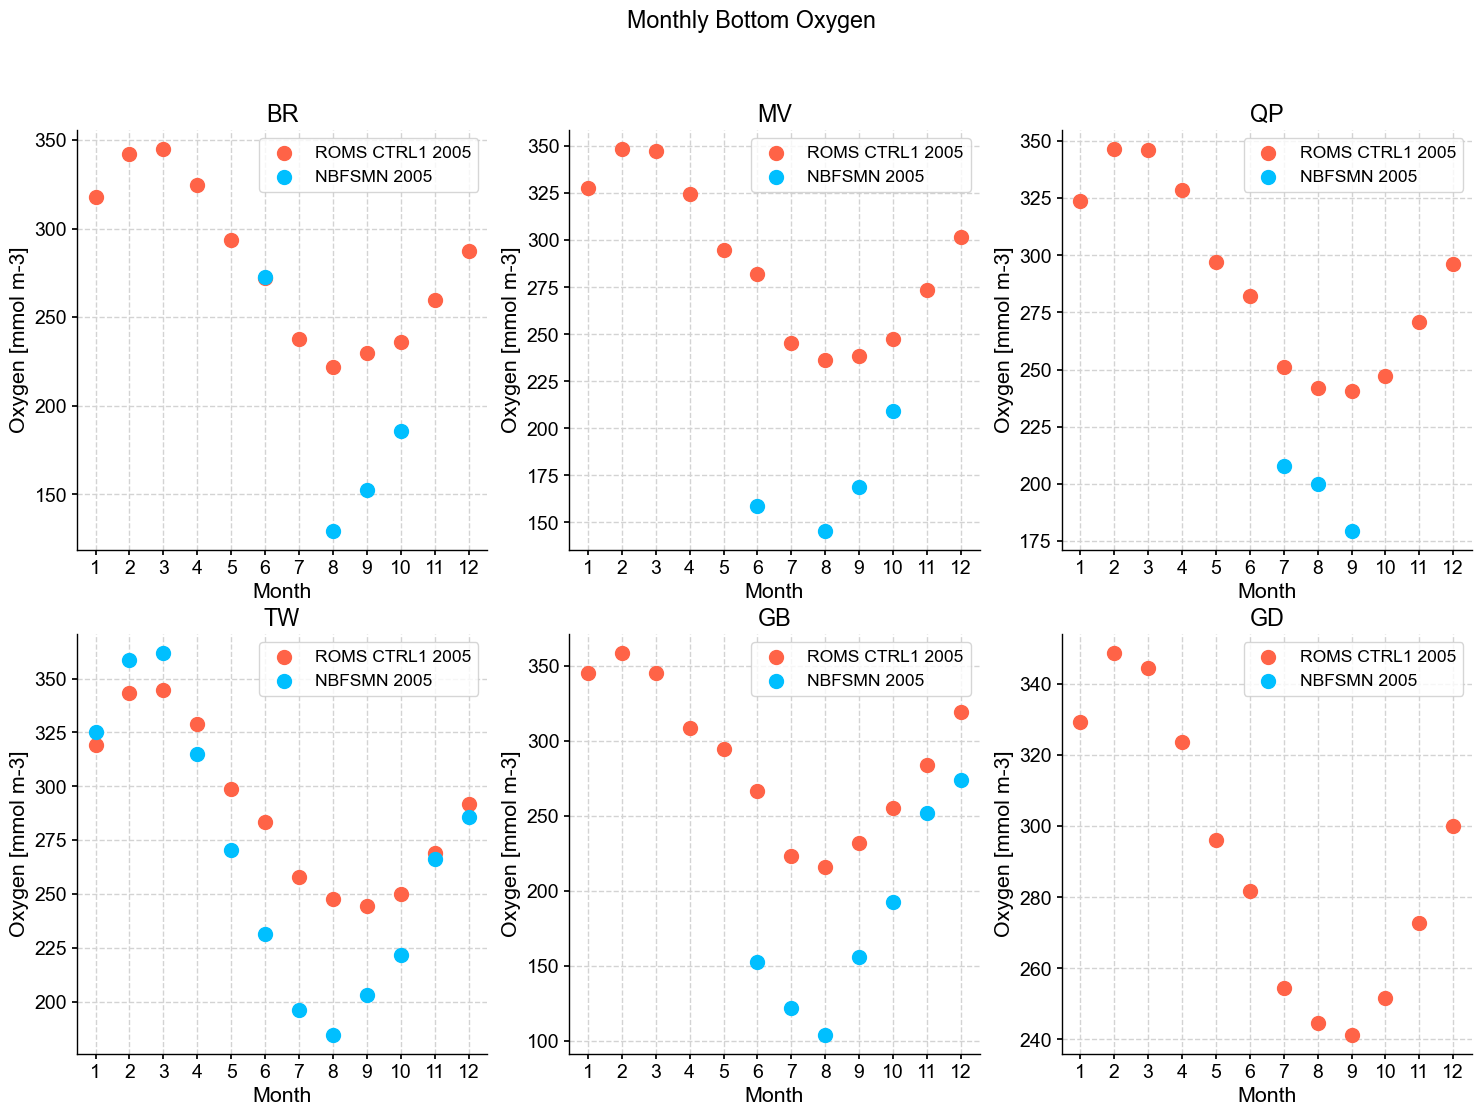

In [21]:
fig, axarr = plt.subplots(nrows = 2, ncols = 3, figsize = [18,12])
axarr = axarr.flatten()

for i in range(len(ds_test.Site)):
    name = ds_test.Site[i].values
    sta = i
    ax = axarr[i]
    data = ds_test.isel(Site = i, Depth = 1)
    ax.scatter(data['Month'], data['oxygen_mod'], label = 'ROMS CTRL1 2005', c = 'tomato', s = 100)
    ax.set_title(name)
    ax.scatter(data['Month'], data['oxygen_obs'], 
              label = 'NBFSMN 2005', c = 'deepskyblue', s = 100)
    ax.legend(frameon=True)
    ax.set_xlabel('Month')
    ax.set_xticks(np.arange(1,13))
    ax.set_ylabel('Oxygen [mmol m-3]') 

fig.suptitle('Monthly Bottom Oxygen')

## Surface NO3

Model overestimates surface NO3 at the beginning of the year. This may be a consequence of this run being the first of the spin-up runs. This is to say, this phenomenon might improve after the spin-up is completed.

Text(0.5, 1.0, 'Monthly Surface NO3 Concentration at PLT')

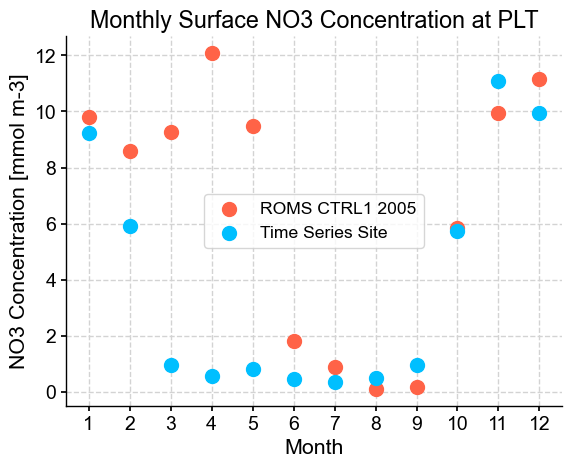

In [22]:
fig, ax = plt.subplots()

ax.scatter(ds_test['Month'], ds_test['NO3_mod'], label = 'ROMS CTRL1 2005', c = 'tomato', s = 100)
ax.scatter(ds_test['Month'], ds_test['NO3_obs'], label = 'Time Series Site', c = 'deepskyblue', s = 100)
ax.legend(frameon=True)
ax.set_xlabel('Month')
ax.set_xticks(np.arange(1,13))
ax.set_ylabel('NO3 Concentration [mmol m-3]') 
ax.set_title('Monthly Surface NO3 Concentration at PLT')

## Surface Si

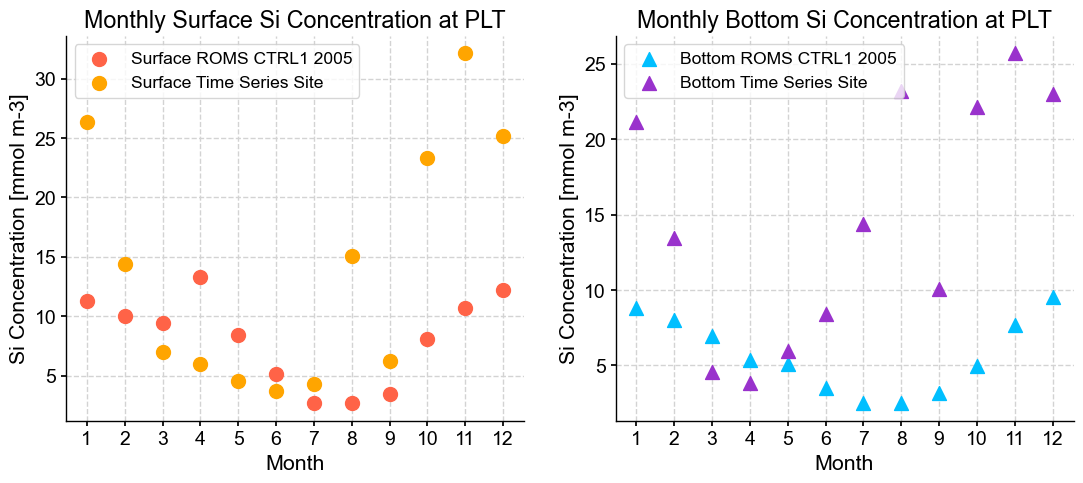

In [23]:
fig, axarr = plt.subplots(ncols = 2, figsize = [13,5])
axarr = axarr.flatten()

ax = axarr[0]
ax.scatter(ds_test['Month'], ds_test['Si_mod'].isel(Depth = 0), label = 'Surface ROMS CTRL1 2005', c = 'tomato', s = 100)
ax.scatter(ds_test['Month'], ds_test['Si_obs'].isel(Depth = 0), label = 'Surface Time Series Site', c = 'orange', s = 100)
ax.set_title('Monthly Surface Si Concentration at PLT')

ax = axarr[1]
ax.scatter(ds_test['Month'], ds_test['Si_mod'].isel(Depth = 1), label = 'Bottom ROMS CTRL1 2005', c = 'deepskyblue', s = 100, marker = '^')
ax.scatter(ds_test['Month'], ds_test['Si_obs'].isel(Depth = 1), label = 'Bottom Time Series Site', c = 'darkorchid', s = 100, marker = '^')
ax.set_title('Monthly Bottom Si Concentration at PLT')

for ax in axarr:
    ax.legend(frameon=True)
    ax.set_xlabel('Month')
    ax.set_xticks(np.arange(1,13))
    ax.set_ylabel('Si Concentration [mmol m-3]') 


## Primary Production

(0.0, 650.0)

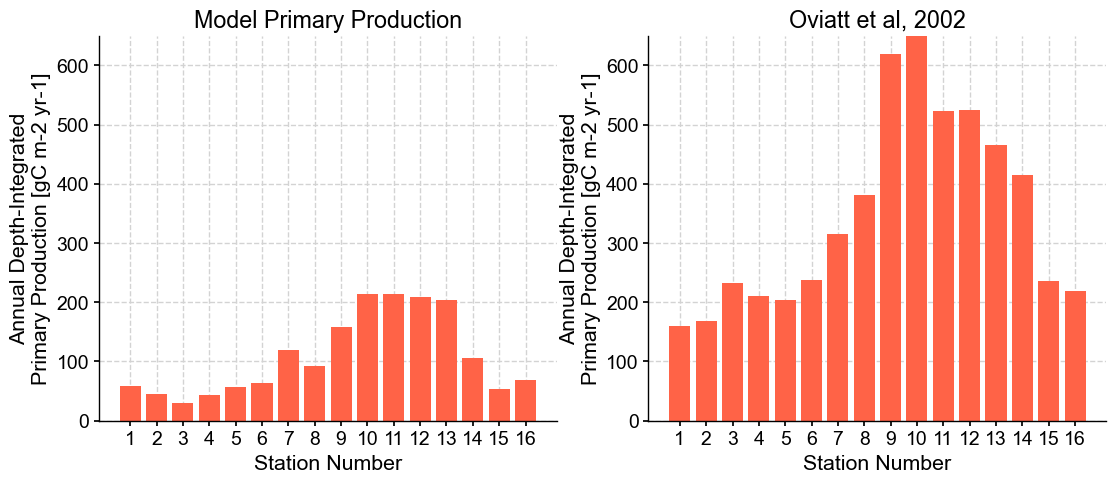

In [24]:
fig, axarr = plt.subplots(ncols = 2, figsize = [13,5])
axarr = axarr.flatten()

ax = axarr[0]

cats = ds_test['Station']
vals1 = ROMS_PP['Annual Net Daytime Production (gC/m^2/yr)']
# vals2 = ROMS_PP['P2 Annual Production [gC m-2 yr-1]']
vals = ds_test['PP_mod']

ax.bar(cats, vals, color = 'tomato')
# ax.bar(cats, vals1, label = 'Small Phytoplankton', color = 'chartreuse')
# ax.bar(cats, vals2, bottom = vals1, label = 'Diatoms', color = 'darkorchid')
ax.legend()
ax.set_ylabel('Annual Depth-Integrated\nPrimary Production [gC m-2 yr-1]')
ax.set_xticks(cats)
ax.set_xlabel('Station Number')
ax.set_title('Model Primary Production')
ax.set_ylim([0,650])

ax = axarr[1]

vals = ds_test['PP_obs']

ax.bar(cats, vals, color = 'tomato')
ax.set_ylabel('Annual Depth-Integrated\nPrimary Production [gC m-2 yr-1]')
ax.set_xticks(cats)
ax.set_xlabel('Station Number')
ax.set_title('Oviatt et al, 2002')
ax.set_ylim([0,650])

# Cost Calculation

## pH Cost

In [25]:

VAR1 = 'pH_mod'
VAR2 = 'pH_obs'
Z = 0
mod = ds_test[VAR1].isel(Site = 0, Depth = Z)
obs = ds_test[VAR2].isel(Site = 0, Depth = Z)
dBR = ((mod - obs)**2).sum()
BR_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 1, Depth = Z)
obs = ds_test[VAR2].isel(Site = 1, Depth = Z)
dMV = ((mod - obs)**2).sum()
MV_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 2, Depth = Z)
obs = ds_test[VAR2].isel(Site = 2, Depth = Z)
dQP = ((mod - obs)**2).sum()
QP_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 3, Depth = Z)
obs = ds_test[VAR2].isel(Site = 3, Depth = Z)
dTW = ((mod - obs)**2).sum()
TW_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 4, Depth = Z)
obs = ds_test[VAR2].isel(Site = 4, Depth = Z)
dGB = ((mod - obs)**2).sum()
GB_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 5, Depth = Z)
obs = ds_test[VAR2].isel(Site = 5, Depth = Z)
dGD = ((mod - obs)**2).sum()
GD_N = np.count_nonzero(~np.isnan(mod - obs))

W = ds_test[VAR2].isel(Depth = Z).std()
N = np.sum([BR_N, MV_N, QP_N, TW_N, GB_N, GD_N ])

pHs_cost = 1/(W**2) * 1/N * np.sum([dBR, dMV, dQP, dTW, dGB, dGD])
print(pHs_cost.values)
ds_test['pH_cost'][Z] = pHs_cost.values

2.8489713494725195


In [26]:

VAR1 = 'pH_mod'
VAR2 = 'pH_obs'
Z = 1
mod = ds_test[VAR1].isel(Site = 0, Depth = Z)
obs = ds_test[VAR2].isel(Site = 0, Depth = Z)
dBR = ((mod - obs)**2).sum()
BR_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 1, Depth = Z)
obs = ds_test[VAR2].isel(Site = 1, Depth = Z)
dMV = ((mod - obs)**2).sum()
MV_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 2, Depth = Z)
obs = ds_test[VAR2].isel(Site = 2, Depth = Z)
dQP = ((mod - obs)**2).sum()
QP_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 3, Depth = Z)
obs = ds_test[VAR2].isel(Site = 3, Depth = Z)
dTW = ((mod - obs)**2).sum()
TW_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 4, Depth = Z)
obs = ds_test[VAR2].isel(Site = 4, Depth = Z)
dGB = ((mod - obs)**2).sum()
GB_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 5, Depth = Z)
obs = ds_test[VAR2].isel(Site = 5, Depth = Z)
dGD = ((mod - obs)**2).sum()
GD_N = np.count_nonzero(~np.isnan(mod - obs))

W = ds_test[VAR2].isel(Depth = Z).std()
N = np.sum([BR_N, MV_N, QP_N, TW_N, GB_N, GD_N ])

pHs_cost = 1/(W**2) * 1/N * np.sum([dBR, dMV, dQP, dTW, dGB, dGD])
print(pHs_cost.values)
ds_test['pH_cost'][Z] = pHs_cost.values

7.38224546408155


## Oxygen Cost

In [27]:

VAR1 = 'oxygen_mod'
VAR2 = 'oxygen_obs'
Z = 0
mod = ds_test[VAR1].isel(Site = 0, Depth = Z)
obs = ds_test[VAR2].isel(Site = 0, Depth = Z)
dBR = ((mod - obs)**2).sum()
BR_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 1, Depth = Z)
obs = ds_test[VAR2].isel(Site = 1, Depth = Z)
dMV = ((mod - obs)**2).sum()
MV_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 2, Depth = Z)
obs = ds_test[VAR2].isel(Site = 2, Depth = Z)
dQP = ((mod - obs)**2).sum()
QP_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 3, Depth = Z)
obs = ds_test[VAR2].isel(Site = 3, Depth = Z)
dTW = ((mod - obs)**2).sum()
TW_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 4, Depth = Z)
obs = ds_test[VAR2].isel(Site = 4, Depth = Z)
dGB = ((mod - obs)**2).sum()
GB_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 5, Depth = Z)
obs = ds_test[VAR2].isel(Site = 5, Depth = Z)
dGD = ((mod - obs)**2).sum()
GD_N = np.count_nonzero(~np.isnan(mod - obs))

W = ds_test[VAR2].isel(Depth = Z).std()
N = np.sum([BR_N, MV_N, QP_N, TW_N, GB_N, GD_N ])

pHs_cost = 1/(W**2) * 1/N * np.sum([dBR, dMV, dQP, dTW, dGB, dGD])
print(pHs_cost.values)
ds_test['oxygen_cost'][Z] = pHs_cost.values

0.3139764433958247


In [28]:

VAR1 = 'oxygen_mod'
VAR2 = 'oxygen_obs'
Z = 1
mod = ds_test[VAR1].isel(Site = 0, Depth = Z)
obs = ds_test[VAR2].isel(Site = 0, Depth = Z)
dBR = ((mod - obs)**2).sum()
BR_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 1, Depth = Z)
obs = ds_test[VAR2].isel(Site = 1, Depth = Z)
dMV = ((mod - obs)**2).sum()
MV_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 2, Depth = Z)
obs = ds_test[VAR2].isel(Site = 2, Depth = Z)
dQP = ((mod - obs)**2).sum()
QP_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 3, Depth = Z)
obs = ds_test[VAR2].isel(Site = 3, Depth = Z)
dTW = ((mod - obs)**2).sum()
TW_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 4, Depth = Z)
obs = ds_test[VAR2].isel(Site = 4, Depth = Z)
dGB = ((mod - obs)**2).sum()
GB_N = np.count_nonzero(~np.isnan(mod - obs))

mod = ds_test[VAR1].isel(Site = 5, Depth = Z)
obs = ds_test[VAR2].isel(Site = 5, Depth = Z)
dGD = ((mod - obs)**2).sum()
GD_N = np.count_nonzero(~np.isnan(mod - obs))

W = ds_test[VAR2].isel(Depth = Z).std()
N = np.sum([BR_N, MV_N, QP_N, TW_N, GB_N, GD_N ])

pHs_cost = 1/(W**2) * 1/N * np.sum([dBR, dMV, dQP, dTW, dGB, dGD])
print(pHs_cost.values)
ds_test['oxygen_cost'][Z] = pHs_cost.values

0.8542201544627346


## PP Cost

In [29]:

VAR1 = 'PP_mod'
VAR2 = 'PP_obs'

mod = ds_test[VAR1]
obs = ds_test[VAR2]
dPP = ((mod - obs)**2).sum()
N = np.count_nonzero(~np.isnan(mod - obs))

W = ds_test[VAR2].std()

PP_cost = 1/(W**2) * 1/N * dPP
print(PP_cost.values)
ds_test['PP_cost'] = PP_cost

2.6330064379051157


## NO3 Cost

In [30]:

VAR1 = 'NO3_mod'
VAR2 = 'NO3_obs'

mod = ds_test[VAR1]
obs = ds_test[VAR2]
dPP = ((mod - obs)**2).sum()
N = np.count_nonzero(~np.isnan(mod - obs))

W = ds_test[VAR2].std()

NO3_cost = 1/(W**2) * 1/N * dPP
print(NO3_cost.values)
ds_test['NO3_cost'] = NO3_cost.values

1.4667426693062713


## Si Cost

In [31]:

VAR1 = 'Si_mod'
VAR2 = 'Si_obs'
Z = 0

mod = ds_test[VAR1].isel(Depth = Z)
obs = ds_test[VAR2].isel(Depth = Z)
dPP = ((mod - obs)**2).sum()
N = np.count_nonzero(~np.isnan(mod - obs))

W = ds_test[VAR2].std()

Si_cost = 1/(W**2) * 1/N * dPP
print(Si_cost.values)
ds_test['Si_cost'][Z] = Si_cost.values

1.4309545710018516


In [32]:
VAR1 = 'Si_mod'
VAR2 = 'Si_obs'
Z = 1

mod = ds_test[VAR1].isel(Depth = Z)
obs = ds_test[VAR2].isel(Depth = Z)
dPP = ((mod - obs)**2).sum()
N = np.count_nonzero(~np.isnan(mod - obs))

W = ds_test[VAR2].std()

Si_cost = 1/(W**2) * 1/N * dPP
print(Si_cost.values)
ds_test['Si_cost'][Z] = Si_cost.values

1.73927798451287


# Plot Cost

Example plot of how cost can be shown. When multiple runs are being evaluated, each run would have its own bar. Since the example here only includes 1 run, there is only 1 bar.

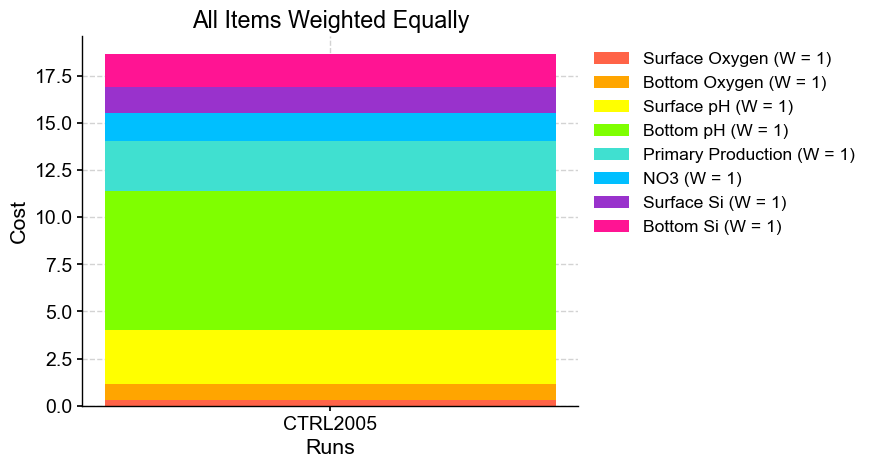

In [33]:
runs = ['CTRL2005']
DOs = [ds_test['oxygen_cost'][0]]
DOb = [ds_test['oxygen_cost'][1]]
pHs = [ds_test['pH_cost'][0]]
pHb = [ds_test['pH_cost'][1]]
PPcost = [ds_test['PP_cost']]
NO3cost = [ds_test['NO3_cost']]
Sis = [ds_test['Si_cost'][0]]
Sib = [ds_test['Si_cost'][1]]


# Create the bar chart
fig, ax = plt.subplots()

# Plot the first group of bars
ax.bar(runs, DOs[0], label='Surface Oxygen (W = 1)', color = 'tomato')
ax.bar(runs, DOb[0], bottom=DOs[0], label='Bottom Oxygen (W = 1)', color = 'orange')
ax.bar(runs, pHs[0], bottom= (DOs[0] + DOb[0]), label='Surface pH (W = 1)', color = 'yellow')
ax.bar(runs, pHb[0], bottom=(DOb[0] + DOs[0] + pHs[0]), label='Bottom pH (W = 1)', color = 'chartreuse')
ax.bar(runs, PPcost, bottom = (DOb[0] + DOs[0] + pHs[0] + pHb[0]), label = 'Primary Production (W = 1)', color = 'turquoise')
ax.bar(runs, NO3cost, bottom = (DOb[0] + DOs[0] + pHs[0] + pHb[0] + PPcost[0]), label = 'NO3 (W = 1)', color = 'deepskyblue')
ax.bar(runs, Sis, bottom = (DOb[0] + DOs[0] + pHs[0] + pHb[0] + PPcost[0] + NO3cost[0]), label = 'Surface Si (W = 1)', color = 'darkorchid')
ax.bar(runs, Sib, bottom = (DOb[0] + DOs[0] + pHs[0] + pHb[0] + PPcost[0] + NO3cost[0] + Sis[0]), label = 'Bottom Si (W = 1)', color = 'deeppink')

# Add labels, title, and legend
ax.set_xlabel('Runs')
ax.set_ylabel('Cost')
ax.set_title('All Items Weighted Equally')
ax.legend(bbox_to_anchor = (1,1))

We can weight each target differently, depending on the target's importance. The weights assigned here are tentative but do reflect our perceived importance of each target, with primary production being the most important and most heavily weighted.

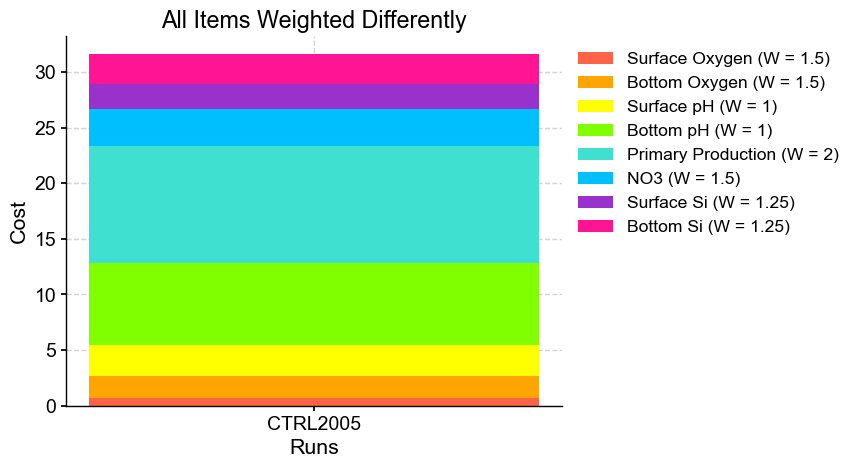

In [34]:
runs = ['CTRL2005']
DOs = [1.5**2 * ds_test['oxygen_cost'][0]]
DOb = [1.5**2 * ds_test['oxygen_cost'][1]]
pHs = [ds_test['pH_cost'][0]]
pHb = [ds_test['pH_cost'][1]]
PPcost = [2**2 * ds_test['PP_cost']]
NO3cost = [1.5**2 * ds_test['NO3_cost']]
Sis = [1.25**2 * ds_test['Si_cost'][0]]
Sib = [1.25**2 * ds_test['Si_cost'][1]]


# Create the bar chart
fig, ax = plt.subplots()

# Plot the first group of bars
ax.bar(runs, DOs[0], label='Surface Oxygen (W = 1.5)', color = 'tomato')
ax.bar(runs, DOb[0], bottom=DOs[0], label='Bottom Oxygen (W = 1.5)', color = 'orange')
ax.bar(runs, pHs[0], bottom= (DOs[0] + DOb[0]), label='Surface pH (W = 1)', color = 'yellow')
ax.bar(runs, pHb[0], bottom=(DOb[0] + DOs[0] + pHs[0]), label='Bottom pH (W = 1)', color = 'chartreuse')
ax.bar(runs, PPcost, bottom = (DOb[0] + DOs[0] + pHs[0] + pHb[0]), label = 'Primary Production (W = 2)', color = 'turquoise')
ax.bar(runs, NO3cost, bottom = (DOb[0] + DOs[0] + pHs[0] + pHb[0] + PPcost[0]), label = 'NO3 (W = 1.5)', color = 'deepskyblue')
ax.bar(runs, Sis, bottom = (DOb[0] + DOs[0] + pHs[0] + pHb[0] + PPcost[0] + NO3cost[0]), label = 'Surface Si (W = 1.25)', color = 'darkorchid')
ax.bar(runs, Sib, bottom = (DOb[0] + DOs[0] + pHs[0] + pHb[0] + PPcost[0] + NO3cost[0] + Sis[0]), label = 'Bottom Si (W = 1.25)', color = 'deeppink')

# Add labels, title, and legend
ax.set_xlabel('Runs')
ax.set_ylabel('Cost')
ax.set_title('All Items Weighted Differently')
ax.legend(bbox_to_anchor = (1,1))

# Add more metadata about overall results

Additional metedata can be added about the interpretaion of the results. This would enable users to make informed decisions about next steps without having to reprocess all the data. Further, this helps the resulting "cost file" stand alone.

In [35]:
note1 = "Primary production is strongly underestimated. I should increase the max specific growth rate, certainly of diatoms and maybe of small phytoplankton. "
note2 = "Si does not have high enough concentrations in fall. How do we replenish Si in the water column after summer? "
note3 = "Bottom pH carried one of the largest costs, but hopefully this will improve once we increase PP. "

ds_test = ds_test.assign_attrs(

    notes=note1+note2+note3,
    BoundaryFile = "bry_osom_cosine_hab_monthly-nuts_grid5_mod11_10level_C_O_2005.nc",
    GridFile = "osom_grid5_mod11.nc",
    InitFile = "osom_cosine_grid5_mod11_10level_2005_ctrl_restart4.nc",
    SSFFile = "frc_rivers_osom_grid5_mod10_10level_v2_cosine15_hab_nuts_obs_2005_linearprof.nc",
    TidalFile = "osom_grid5_mod10_tidalforcing_2005.nc",
    WindFile = "frc_NAM_wind_fields_OSOM_2005_ref-2005-01-01.nc", 
    SWradFile = "frc_bulk8_point_osom_2005_ref-2005-01-01_localswrad.nc", 
    NTIMES = "1576800",
    nI = "498", 
    nJ = "548",
    nZ = "10",

)

# Save Cost File as .nc
Cost file saved as a NetCDF file with all costs being weighted equally.

In [37]:
PATH = '/Users/akbaskind/Desktop/COST_FILES/'
ds_test.to_netcdf(PATH+"CTRL2005.nc")

In [41]:
PATH+"CTRL2005.nc"

'/Users/akbaskind/Desktop/COST_FILES/CTRL2005.nc'

# Plot Cost Comparison

Example of comparing the costs of multiple runs. This example is done with 2 separate years from the model spin-up that use the same parameter values and model inputs.

In [38]:
PATH = '/Users/akbaskind/Desktop/COST_FILES/'
CTRL2 = xr.open_mfdataset(PATH+"CTRL2_2005.nc")
CTRL5 = xr.open_mfdataset(PATH+"CTRL5_2005.nc")

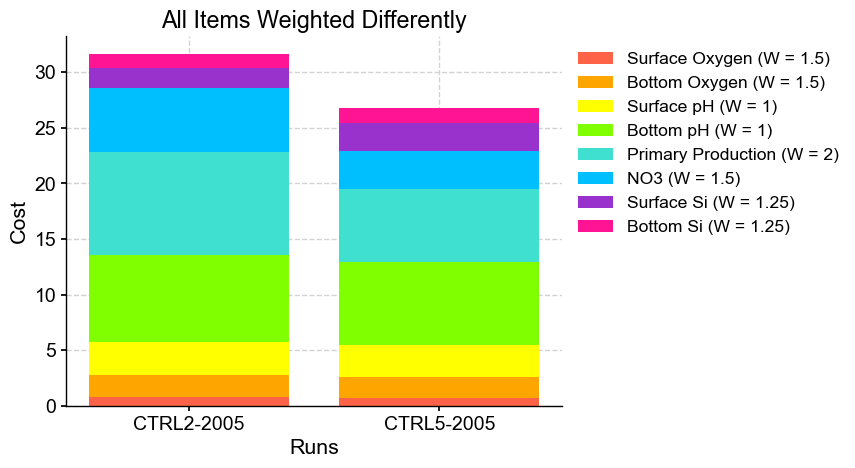

In [39]:
runs = ['CTRL2-2005', 'CTRL5-2005']
DOs = [1.5**2 * CTRL2['oxygen_cost'][0], 1.5**2 * CTRL5['oxygen_cost'][0]]
DOb = [1.5**2 * CTRL2['oxygen_cost'][1], 1.5**2 * CTRL5['oxygen_cost'][1]]
pHs = [CTRL2['pH_cost'][0], CTRL5['pH_cost'][0]]
pHb = [CTRL2['pH_cost'][1], CTRL5['pH_cost'][1]]
PPcost = [2**2 * CTRL2['PP_cost'], 2**2 * CTRL5['PP_cost']]
NO3cost = [1.5**2 * CTRL2['NO3_cost'], 1.5**2 * CTRL5['NO3_cost']]
Sis = [1.25**2 * CTRL2['Si_cost'][0], 1.25**2 * CTRL5['Si_cost'][0]]
Sib = [1.25**2 * CTRL2['Si_cost'][1], 1.25**2 * CTRL5['Si_cost'][1]]


# Create the bar chart
fig, ax = plt.subplots()

# Plot the first group of bars
ax.bar(runs, np.array(DOs), label='Surface Oxygen (W = 1.5)', color = 'tomato')
ax.bar(runs, np.array(DOb), bottom=np.array(DOs), label='Bottom Oxygen (W = 1.5)', color = 'orange')
ax.bar(runs, np.array(pHs), bottom= (np.array(DOs) + np.array(DOb)), label='Surface pH (W = 1)', color = 'yellow')
ax.bar(runs, np.array(pHb), bottom=(np.array(DOb) + np.array(DOs) + np.array(pHs)), label='Bottom pH (W = 1)', color = 'chartreuse')
ax.bar(runs, PPcost, bottom = (np.array(DOb) + np.array(DOs) + np.array(pHs) + np.array(pHb)), label = 'Primary Production (W = 2)', color = 'turquoise')
ax.bar(runs, NO3cost, bottom = (np.array(DOb) + np.array(DOs) + np.array(pHs) + np.array(pHb) + np.array(PPcost)), label = 'NO3 (W = 1.5)', color = 'deepskyblue')
ax.bar(runs, Sis, bottom = (np.array(DOb) + np.array(DOs) + np.array(pHs) + np.array(pHb) + np.array(PPcost) + np.array(NO3cost)), label = 'Surface Si (W = 1.25)', color = 'darkorchid')
ax.bar(runs, Sib, bottom = (np.array(DOb) + np.array(DOs) + np.array(pHs) + np.array(pHb) + np.array(PPcost) + np.array(NO3cost) + np.array(Sis)), label = 'Bottom Si (W = 1.25)', color = 'deeppink')

# Add labels, title, and legend
ax.set_xlabel('Runs')
ax.set_ylabel('Cost')
ax.set_title('All Items Weighted Differently')
ax.legend(bbox_to_anchor = (1,1))

In [40]:
!jupyter nbconvert --to latex COST_FUNCTION.ipynb

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook COST_FUNCTION.ipynb to latex
[NbConvertApp] Support files will be in COST_FUNCTION_files/
[NbConvertApp] Making directory COST_FUNCTION_files
[NbConvertApp] Making directory COST_FUNCTION_files
[NbConvertApp] Making directory COST_FUNCTION_files
[NbConvertApp] Making directory COST_FUNCTION_files
[NbConvertApp] Making directory COST_FUNCTION_files
[NbConvertApp] Making directory COST_FUNCTION_files
[NbConvertApp] Making directory COST_FUNCTION_files
[NbConvertApp] Making directory COST_FUNCTION_files
[NbConvertApp] Making directory COST_FUNCTION_files
[NbConvertApp] Making directory COST_FUNCTION_files
[NbConvertApp] Writing 190199 bytes to COST_FUNCTION.tex
